In [1]:
import sys; sys.path.append("/data/software/symphony/build")
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import flaremodel as fm
import symphonyPy

SAVE_PLOT = True
symphony_njobs = 12

# Setup parameters used in comparison
ne = 1
theta_E = 30.
p = 3.
gamma_min = 1.1
gamma_max = 1e4
p_angle = np.pi/8
B = 10
kappa = p+1 # p = 3.5
kappa_w = theta_E

nu = np.logspace(8, 16, 50)
nu_c = fm.nu_crit(1, B, p_angle)

# We use basic grid integration scheme, steps is grid points per factor of 10 in gamma, 
# g_min_br/g_max_br are gamma limits used in integration. These are the defaults and for most
# purposes should be enough. Powerlaw distribution overwrites these so that integration is limited
# to given gamma_min/gamma_max parameters of the distribution.
steps = 50
g_min_br = 1.1
g_max_br = 1e7

nu_c = fm.nu_crit(1., B, p_angle)

In [2]:
def j_nu_sym(nu, ne, B, params, edist, incang, pol=symphonyPy.STOKES_I):
    
    if edist == "thermal":
        fun = lambda nu_t: symphonyPy.j_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.MAXWELL_JUETTNER, pol, 
                         params[0], 0, 0, 0, 0, 0, 0)  
    elif edist == "powerlaw":
        fun = lambda nu_t: symphonyPy.j_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.POWER_LAW, pol, 
                         0, params[0], params[1], params[2], params[2], 0, 0)
    elif edist == "kappa":
        fun = lambda nu_t: symphonyPy.j_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.KAPPA_DIST, pol, 
                         0, 0, 0, 0, 0, params[0], params[1])
    
    return np.array(Parallel(n_jobs=symphony_njobs)(delayed(fun)(nu_t) for nu_t in nu))

def a_nu_sym(nu, ne, B, params, edist, incang, pol=symphonyPy.STOKES_I):
    
    if edist == "thermal":
        fun = lambda nu_t: symphonyPy.alpha_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.MAXWELL_JUETTNER, pol, 
                         params[0], 0, 0, 0, 0, 0, 0)  
    elif edist == "powerlaw":
        fun = lambda nu_t: symphonyPy.alpha_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.POWER_LAW, pol, 
                         0, params[0], params[1], params[2], params[2], 0, 0)
    elif edist == "kappa":
        fun = lambda nu_t: symphonyPy.alpha_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.KAPPA_DIST, pol, 
                         0, 0, 0, 0, 0, params[0], params[1])
    
    return np.array(Parallel(n_jobs=symphony_njobs)(delayed(fun)(nu_t) for nu_t in nu))

def rho_nu_sym(nu, ne, B, params, edist, incang, pol=symphonyPy.STOKES_I):
    
    if edist == "thermal":
        fun = lambda nu_t: symphonyPy.rho_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.MAXWELL_JUETTNER, pol, 
                         params[0], 0, 0, 0, 0, 0, 0)  
    elif edist == "powerlaw":
        fun = lambda nu_t: symphonyPy.rho_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.POWER_LAW, pol, 
                         0, params[0], params[1], params[2], params[2], 0, 0)
    elif edist == "kappa":
        fun = lambda nu_t: symphonyPy.rho_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.KAPPA_DIST, pol, 
                         0, 0, 0, 0, 0, params[0], params[1])
    
    return np.array(Parallel(n_jobs=symphony_njobs)(delayed(fun)(nu_t) for nu_t in nu))

In [3]:
j_nu_pl_br_I = fm.j_nu_brute(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", incang=p_angle, steps=steps)
j_nu_pl_br_Q = fm.j_nu_brute(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", incang=p_angle, steps=steps, pol=fm.STOKES_Q)
j_nu_pl_br_V = fm.j_nu_brute(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", incang=p_angle, steps=steps, pol=fm.STOKES_V)

j_nu_pl_sym_I = j_nu_sym(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", p_angle)
j_nu_pl_sym_Q = j_nu_sym(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", p_angle, pol=symphonyPy.STOKES_Q)
j_nu_pl_sym_V = j_nu_sym(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", p_angle, pol=symphonyPy.STOKES_V)

(-0.08001650386823854, 1.0)

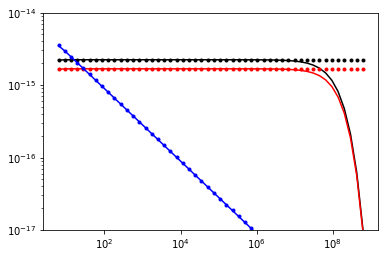

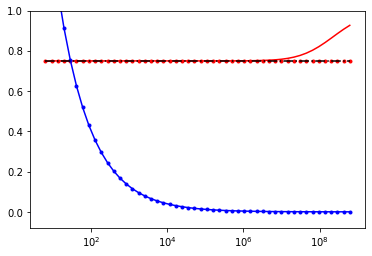

In [4]:
plt.loglog(nu/nu_c, j_nu_pl_br_I*nu, 'k-')
plt.loglog(nu/nu_c, j_nu_pl_sym_I*nu, 'k.')
plt.loglog(nu/nu_c, j_nu_pl_br_Q*nu, 'r-')
plt.loglog(nu/nu_c, -j_nu_pl_sym_Q*nu, 'r.')
plt.loglog(nu/nu_c, j_nu_pl_br_V*nu, 'b-')
plt.loglog(nu/nu_c, j_nu_pl_sym_V*nu, 'b.')
plt.ylim([1e-17, 1e-14])

plt.figure()
plt.semilogx(nu/nu_c, j_nu_pl_br_Q/j_nu_pl_br_I, 'r-')
plt.semilogx(nu/nu_c, -j_nu_pl_sym_Q/j_nu_pl_sym_I, 'r.')
plt.semilogx(nu/nu_c, j_nu_pl_br_V/j_nu_pl_br_I, 'b-')
plt.semilogx(nu/nu_c, j_nu_pl_sym_V/j_nu_pl_sym_I, 'b.')
plt.semilogx(nu/nu_c, (p+1)/(p+7./3)+np.zeros_like(nu), 'k-.')
plt.ylim(top=1)

In [5]:
j_nu_th_br_I = fm.j_nu_brute(nu, ne, B, [theta_E], "thermal", incang=p_angle, gamma_min=1., steps=steps)
j_nu_th_br_Q = fm.j_nu_brute(nu, ne, B, [theta_E], "thermal", incang=p_angle, gamma_min=1., steps=steps, pol=fm.STOKES_Q)
j_nu_th_br_V = fm.j_nu_brute(nu, ne, B, [theta_E], "thermal", incang=p_angle, gamma_min=1., steps=steps, pol=fm.STOKES_V)
j_nu_th_sym_I = j_nu_sym(nu, ne, B, [theta_E], "thermal", p_angle, pol=symphonyPy.STOKES_I)
j_nu_th_sym_Q = j_nu_sym(nu, ne, B, [theta_E], "thermal", p_angle, pol=symphonyPy.STOKES_Q)
j_nu_th_sym_V = j_nu_sym(nu, ne, B, [theta_E], "thermal", p_angle, pol=symphonyPy.STOKES_V)

(-0.04859869280364611, 1.1)

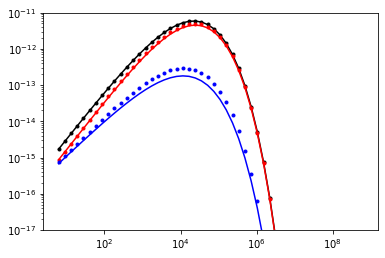

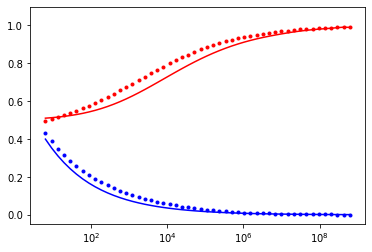

In [6]:
plt.loglog(nu/nu_c, j_nu_th_br_I*nu, 'k-')
plt.loglog(nu/nu_c, j_nu_th_sym_I*nu, 'k.')
plt.loglog(nu/nu_c, j_nu_th_br_Q*nu, 'r-')
plt.loglog(nu/nu_c, -j_nu_th_sym_Q*nu, 'r.')
plt.loglog(nu/nu_c, j_nu_th_br_V*nu, 'b-')
plt.loglog(nu/nu_c, j_nu_th_sym_V*nu, 'b.')
plt.ylim([1e-17, 1e-11])

plt.figure()
plt.semilogx(nu/nu_c, j_nu_th_br_Q/j_nu_th_br_I, 'r-')
plt.semilogx(nu/nu_c, -j_nu_th_sym_Q/j_nu_th_sym_I, 'r.')
plt.semilogx(nu/nu_c, j_nu_th_br_V/j_nu_th_br_I, 'b-')
plt.semilogx(nu/nu_c, j_nu_th_sym_V/j_nu_th_sym_I, 'b.')
plt.ylim(top=1.1)

In [7]:
j_nu_kp_br_I = fm.j_nu_brute(nu, ne, B, [kappa, kappa_w], "kappa", incang=p_angle, steps=steps)
j_nu_kp_br_Q = fm.j_nu_brute(nu, ne, B, [kappa, kappa_w], "kappa", incang=p_angle, steps=steps, pol=fm.STOKES_Q)
j_nu_kp_br_V = fm.j_nu_brute(nu, ne, B, [kappa, kappa_w], "kappa", incang=p_angle, steps=steps, pol=fm.STOKES_V)
j_nu_kp_sym_I = j_nu_sym(nu, ne, B, [kappa, kappa_w], "kappa", p_angle, pol=symphonyPy.STOKES_I)
j_nu_kp_sym_Q = j_nu_sym(nu, ne, B, [kappa, kappa_w], "kappa", p_angle, pol=symphonyPy.STOKES_Q)
j_nu_kp_sym_V = j_nu_sym(nu, ne, B, [kappa, kappa_w], "kappa", p_angle, pol=symphonyPy.STOKES_V)

(-0.037340824672367226, 1.0)

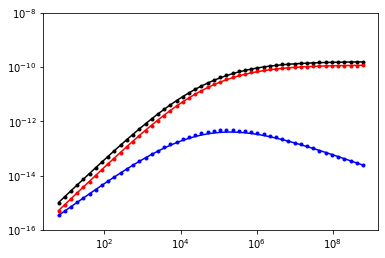

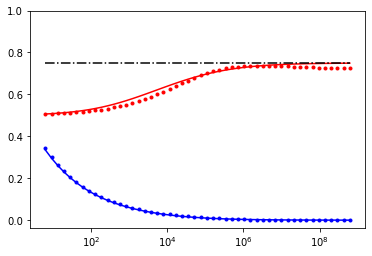

In [8]:
plt.loglog(nu/nu_c, j_nu_kp_br_I*nu, 'k-')
plt.loglog(nu/nu_c, j_nu_kp_sym_I*nu, 'k.')
plt.loglog(nu/nu_c, j_nu_kp_br_Q*nu, 'r-')
plt.loglog(nu/nu_c, -j_nu_kp_sym_Q*nu, 'r.')
plt.loglog(nu/nu_c, j_nu_kp_br_V*nu, 'b-')
plt.loglog(nu/nu_c, j_nu_kp_sym_V*nu, 'b.')
plt.ylim([1e-16, 1e-8])

plt.figure()
plt.semilogx(nu/nu_c, j_nu_kp_br_Q/j_nu_kp_br_I, 'r-')
plt.semilogx(nu/nu_c, -j_nu_kp_sym_Q/j_nu_kp_sym_I, 'r.')
plt.semilogx(nu/nu_c, j_nu_kp_br_V/j_nu_kp_br_I, 'b-')
plt.semilogx(nu/nu_c, j_nu_kp_sym_V/j_nu_kp_sym_I, 'b.')
plt.semilogx(nu/nu_c, (p+1)/(p+7./3)+np.zeros_like(nu), 'k-.')
plt.ylim(top=1)

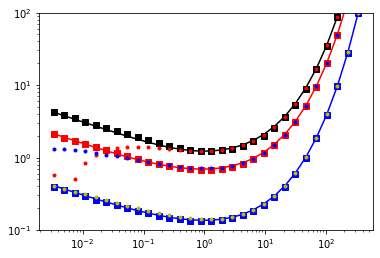

In [9]:
cs = ['k', 'r', 'b', 'y']

for i, THETA in enumerate([3, 10, 100]):
    nu = np.logspace(5, 10, 30)*THETA**2
    p_angle = np.pi/4.
    nu_c = fm.nu_crit(THETA, B, p_angle)
    rho_nu_th_br_V = fm.rho_nu_brute(nu, ne, B, [THETA], "thermal", incang=p_angle, steps=steps, pol=fm.STOKES_V)
    a_nu_th_br_I = fm.a_nu_brute(nu, ne, B, [THETA], "thermal", incang=p_angle, steps=steps, pol=fm.STOKES_I)
    rho_nu_th_hg_V = fm.rho_nu_fit_huang11(nu, ne, B, [THETA], "thermal", incang=p_angle, steps=steps, pol=fm.STOKES_V)
    rho_nu_th_sym_V = rho_nu_sym(nu, ne, B, [THETA], "thermal", p_angle, pol=symphonyPy.STOKES_V)
    
    plt.loglog(nu/nu_c, abs(rho_nu_th_br_V)/a_nu_th_br_I, '%s-' % cs[i])
    plt.loglog(nu/nu_c, abs(rho_nu_th_hg_V)/a_nu_th_br_I, '%ss' % cs[i])
    plt.loglog(nu/nu_c, abs(rho_nu_th_sym_V)/a_nu_th_br_I, '%s.' % cs[i+1])

    plt.ylim([1e-1, 1e2])
    

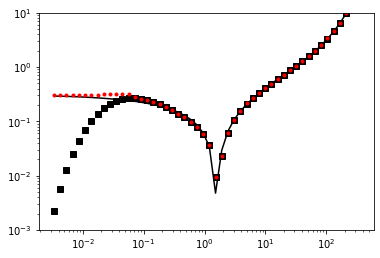

In [10]:
cs = ['k', 'r', 'b', 'y']

for i, THETA in enumerate([10.]):
    nu = np.logspace(5, 10, 50)*THETA**2
    p_angle = np.pi/4.
    nu_c = fm.nu_crit(THETA, B, p_angle)
    rho_nu_th_br_Q = fm.rho_nu_brute(nu, ne, B, [THETA], "thermal", incang=p_angle, steps=steps, pol=fm.STOKES_Q)
    a_nu_th_br_I = fm.a_nu_brute(nu, ne, B, [THETA], "thermal", incang=p_angle, steps=steps, pol=fm.STOKES_I)
    rho_nu_th_hg_Q = fm.rho_nu_fit_huang11(nu, ne, B, [THETA], "thermal", incang=p_angle, steps=steps, pol=fm.STOKES_Q)
    rho_nu_th_sym_Q = rho_nu_sym(nu, ne, B, [THETA], "thermal", p_angle, pol=symphonyPy.STOKES_Q)
    
    plt.loglog(nu/nu_c, abs(rho_nu_th_br_Q)/a_nu_th_br_I, '%s-' % cs[i])
    plt.loglog(nu/nu_c, abs(rho_nu_th_hg_Q)/a_nu_th_br_I, '%ss' % cs[i])
    plt.loglog(nu/nu_c, abs(rho_nu_th_sym_Q)/a_nu_th_br_I, '%s.' % cs[i+1])

    plt.ylim([1e-3, 1e1])